# Contact Graph Generator

In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.incremental_contact_graph import IncrementalContactGraph
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
# logging.getLogger("large_gcs").setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

## Simple Demo 2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-04-01


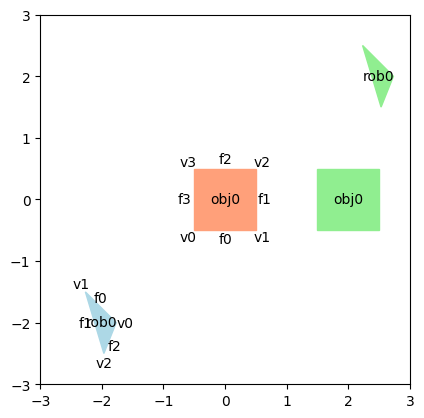

In [2]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 42.35it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 480.21it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 11/11 [00:00<00:00, 2786.24it/s]
INFO:large_gcs.graph.contact_graph:11 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 5247.93it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 7664.60it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 78/78 [00:00<00:00, 12358.09it/s]
INFO:large_gcs.graph.contact_graph:52 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 7650.89it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
1

In [4]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 42.13it/s]
INFO:large_gcs.graph.contact_graph:Loading 11 contact pair modes for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 511.57it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 8531.68it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 16498.02it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 8180.32it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 52/52 [00:00<00:00, 3646.31it/s]
INFO:large_gcs.graph.graph:Adding 52 edges to graph...
100%|██████████| 52/52 [00:00<00:00, 2450.66it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=52, so

In [5]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 17623.13it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9177.91it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 38.79it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 6679.60it/s]


In [6]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 23237.14it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 8811.56it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 45.93it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 4108.62it/s]


### Testing solution methods

In [7]:
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.FULL,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.FULL
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.154, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 2 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 2, vertex_coverage: 0.231, edge_coverage: 0.0192, time_wall_clock: 0.0229, n_gcs_solves: 2, gcs_solve_time_total: 0.00159, gcs_solve_time_iter_mean: 0.000797, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 7.87e-05, gcs_solve_time_iter_min: 0.000718, gcs_solve_time_iter_max:

In [ ]:
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_under
)
gcs_astar = GcsAstar(
    cg,
    cost_estimator=cost_estimator,
    use_convex_relaxation=False,
)
sol = gcs_astar.run()

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=False)
print(sol)

In [ ]:
sol = cg.solve_shortest_path(use_convex_relaxation=True)
print(sol)

## Simple Demo 3 (Target Region)

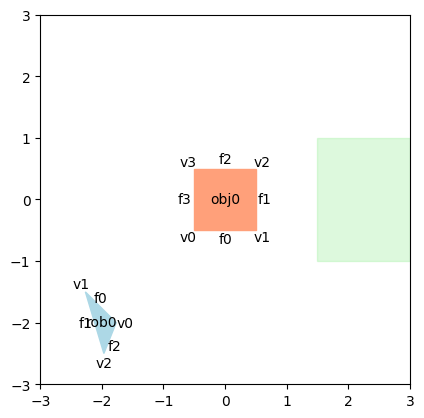

In [8]:
ws = 3
target_regions = [
    ContactRegionParams(
        region_vertices=[[1.5, -1], [1.5, 1], [3, 1], [3, -1]], obj_indices=[0]
    ),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_3",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [9]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 33.48it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 322.43it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 11/11 [00:00<00:00, 3223.23it/s]
INFO:large_gcs.graph.contact_graph:11 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 6173.68it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 8216.69it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 78/78 [00:00<00:00, 7395.35it/s]
INFO:large_gcs.graph.contact_graph:72 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 72/72 [00:00<00:00, 6410.99it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
10

In [10]:
generator.generate_incremental_contact_graph()

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 26546.23it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 15592.21it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 37.91it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 26081.03it/s]


In [11]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 11229.73it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 11667.05it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 39.32it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (55)
100%|██████████| 55/55 [00:00<00:00, 5561.40it/s]


## Triangle Challenge 2

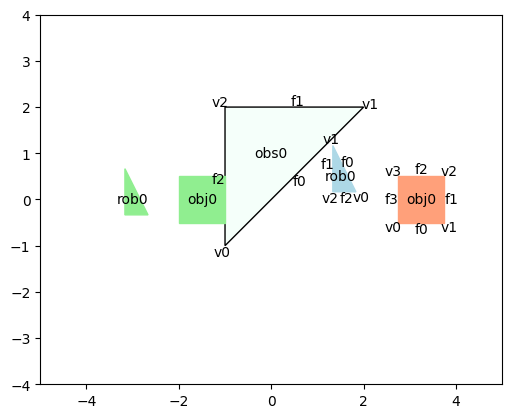

In [16]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [17]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 65.55it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 445.61it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3661.28it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 11193.55it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 12086.75it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 7004.02it/s]
INFO:large_gcs.graph.contact_graph:6120 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 6651.01it/s]
INFO:large_gcs.graph.contact_graph:Creat

In [18]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 77.80it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...


INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 476.81it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 10332.06it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 9769.38it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 7086.66it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 4830.69it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 5029.56it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6120, source=[array([3.250, 0.000]), array([1.500, 0.500])], target=[array([-1.500, 0.000]), array([-3,  0])], workspace=array([[-5,  5],
       [-4,  4]]), default_costs_constraints=None)


In [19]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 12446.01it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 5507.95it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 70.62it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 6708.00it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 35394.97it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9177.91it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 74.79it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 8442.29it/s]


### Testing solution methods

In [15]:
logging.getLogger("large_gcs.algorithms.gcs_astar_convex_restriction").setLevel(
    logging.DEBUG
)
cost_estimator = ShortcutEdgeCE(
    cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted
)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', 'target'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.011, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
DEBUG:large_gcs.algorithms.gcs_astar_convex_restriction:edge source -> ('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0') is feasible, new dist: 238.26001654659783, added to pq True
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', "('NC|obs0_f0-obj0_v3',

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

## Triangle Challenge 3

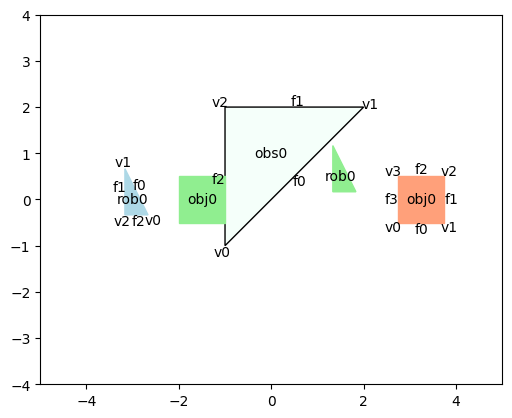

In [20]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [21]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 75.52it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 405.34it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3876.34it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 11432.41it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 11008.67it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 7269.16it/s]
INFO:large_gcs.graph.contact_graph:6120 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 8863.67it/s]
INFO:large_gcs.graph.contact_graph:Creat

In [22]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 24244.53it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 14716.86it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 64.87it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 4987.81it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 27413.75it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 16384.00it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 72.29it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 9795.68it/s]


In [23]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 79.14it/s]
INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:00<00:00, 487.01it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 8593.82it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 9177.69it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6120/6120 [00:00<00:00, 7427.92it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6120/6120 [00:01<00:00, 5341.59it/s]
INFO:large_gcs.graph.graph:Adding 6120 edges to graph...
100%|██████████| 6120/6120 [00:01<00:00, 5026.96it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertic

In [24]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 12965.39it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 9372.75it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 61.39it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 12777.63it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 32388.45it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 21732.15it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 70.51it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 5868.00it/s]


## Triangle Challenge 4 (Target Region)

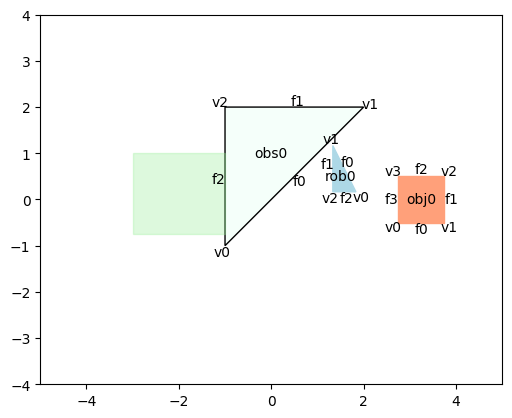

In [25]:
ws_x = 5
ws_y = 4
target_region_params = [
    ContactRegionParams(
        region_vertices=[[-3, -0.75], [-3, 1], [-1, -0.75], [-1, 1]], obj_indices=[0]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_trichal4",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [26]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 57.91it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:00<00:00, 466.00it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3367.62it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 10717.28it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 14093.66it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 16290/16290 [00:02<00:00, 7150.11it/s]
INFO:large_gcs.graph.contact_graph:6176 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6176/6176 [00:00<00:00, 9143.66it/s]
INFO:large_gcs.graph.contact_graph:Creat

In [27]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 10407.70it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 21290.88it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 71.95it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 6449.22it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 26051.58it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 6996.34it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 74.30it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (67)
100%|██████████| 67/67 [00:00<00:00, 7120.70it/s]


## Maze a1

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

## Maze a2

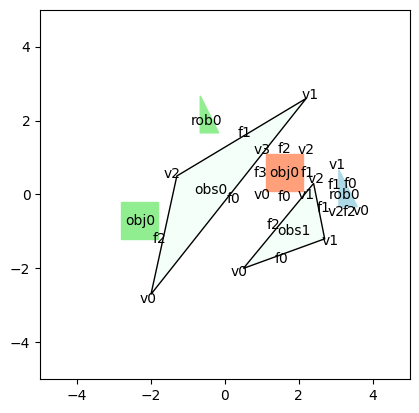

In [28]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [29]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 61.32it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 8100 sets...
100%|██████████| 8100/8100 [00:21<00:00, 381.74it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 8100/8100 [00:01<00:00, 5865.76it/s]
INFO:large_gcs.graph.contact_graph:836 sets remain after removing 7264 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 838/838 [00:00<00:00, 10864.56it/s]
INFO:large_gcs.graph.graph:Adding 838 vertices to graph...
100%|██████████| 838/838 [00:00<00:00, 12027.48it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 350703/350703 [00:48<00:00, 7173.61it/s]
INFO:large_gcs.graph.contact_graph:29994 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 29994/29994 [00:03<00:00, 8771.24it/s]
INFO:large_gcs.graph.contact

In [30]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 67.60it/s]
INFO:large_gcs.graph.contact_graph:Loading 35 contact pair modes for 4 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 836 sets...
100%|██████████| 836/836 [00:02<00:00, 414.74it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 838/838 [00:00<00:00, 11124.70it/s]
INFO:large_gcs.graph.graph:Adding 838 vertices to graph...
100%|██████████| 838/838 [00:00<00:00, 10377.68it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 29994/29994 [00:03<00:00, 8018.75it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 29994/29994 [00:05<00:00, 5015.83it/s]
INFO:large_gcs.graph.graph:Adding 29994 edges to graph...
100%|██████████| 29994/29994 [00:06<00:00, 4954.37it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18),

In [31]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 11413.07it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 11320.66it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 59.33it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (132)
100%|██████████| 132/132 [00:00<00:00, 7272.21it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 2/2 [00:00<00:00, 32513.98it/s]
INFO:large_gcs.graph.graph:Adding 2 vertices to graph...
100%|██████████| 2/2 [00:00<00:00, 17772.47it/s]
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 87.85it/s]
INFO:large_gcs.graph.incremental_contact_graph:Calculating adjacent contact pair modes (132)
100%|██████████| 132/132 [00:00<00:00, 4527.89it/s]


## StackPush

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a1",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()

In [ ]:
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)

In [ ]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(
        region_vertices=[[3, 0], [3, -3], [6, 0], [6, -3]], obj_indices=[0, 1, 2]
    ),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2]]],
    obj_vertices=[
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
        [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
    ],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate_incremental_contact_graph()
cg_inc = IncrementalContactGraph.load_from_file(params.inc_graph_file_path)